## Functions

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Itertools
import itertools

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Sk-learn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "liner"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    if confint != None:
      ci = confint
      ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    #ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

# Notebook: Markov Chain

- **Goal**: implementation of markov chain models for short-term prediction of price changes

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


## OLD - Read data 

#### Read data

In [ ]:
zip_name = "data/catalog_sample.zip"
file_name = "catalog_sample.json"
filetype = "json"
df_og = zip_2_dataframe(zip_name, file_name, filetype)

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
df = clean_data(df_og.copy())
df = add_ids(df)

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Order products by number of changes in time series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


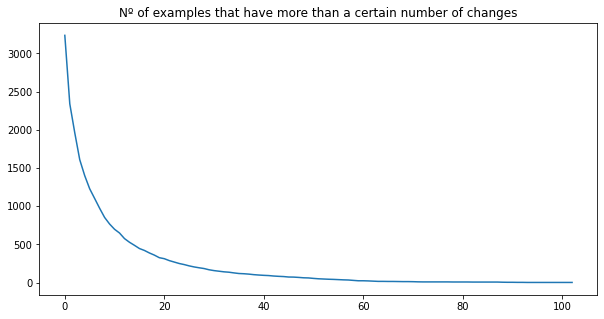

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "liner"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df


df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

counts = []
for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
  counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts)
#ax.set_yscale('log')
plt.title("Nº of examples that have more than a certain number of changes");

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[2]]
#product_id = [3234]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  321


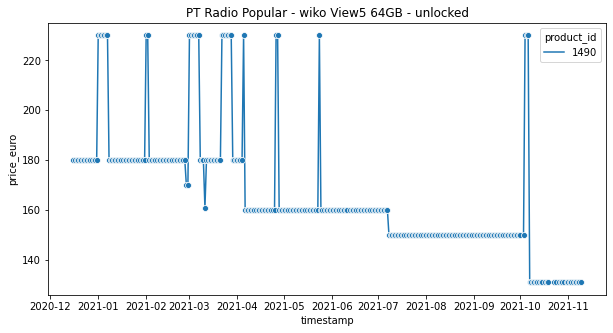

In [ ]:
show_time_series(df_product, "product_id", info)

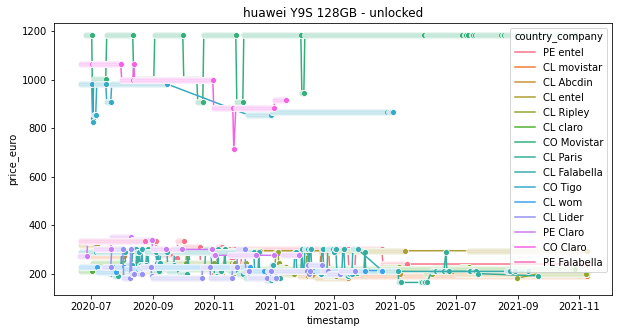

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

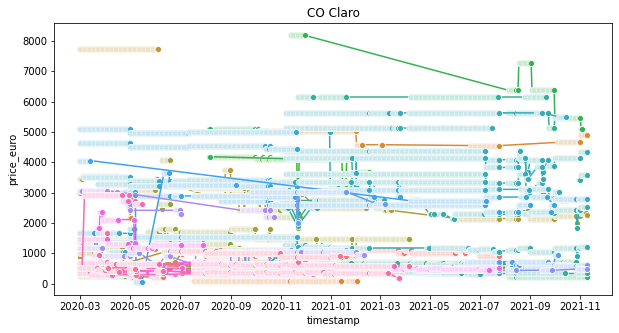

In [ ]:
df_company, info = select_time_series(df, "company_id", company_id)
show_time_series(df_company, "company_id", info)

## Read data

In [ ]:
##### FILTRAR POR NÙMERO DE AMOSTRAS

In [ ]:
# -1 -> down
#  0 -> same
#  1 -> up
#  2 -> missing

In [ ]:
df_all = pd.read_pickle("df_all").reset_index().set_index("product_id")
df_all["states"] = df_all["states"] - 1

n_samples = df_all.dropna().groupby(by = "product_id").count().price_euro
n_changes = df_all.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

n_changes_flt = n_changes[n_changes > 5]
n_samples_flt = n_samples.loc[n_changes_flt.index]
n_samples_flt = n_samples_flt[n_samples_flt > 90]
n_changes_flt = n_changes_flt.loc[n_samples_flt.index]
n_samples_flt.name = "n_samples"
n_changes_flt.name = "n_changes"

df_all_flt = df_all.loc[n_changes_flt.index]
df_all_flt = df_all_flt.reset_index().merge(pd.DataFrame(n_samples_flt).reset_index(), on = "product_id", how = "left").merge(pd.DataFrame(n_changes_flt).reset_index(), on = "product_id", how = "left").drop_duplicates().set_index("product_id")
df_all_flt["changes_samples_ratio"] = df_all_flt["n_changes"]/df_all_flt["n_samples"]
df_all_flt["weekday"] = df_all_flt.timestamp.dt.weekday

In [ ]:
def get_discrete_df(df, features, lags, univariate_multivariate):
  regressors = []
  for feature in features:
    for lag in range(1, lags+1):
      regressor = feature + "_lag_" + str(lag)
      df[regressor] = df.groupby(by = "product_id")[feature].shift(lag)
      regressors.append(regressor)
  return df, regressors

def get_X_y(df, features, lags, filter_missing_values = True):

  df = df.copy()

  univariate_multivariate = 0

  df, regressors = get_discrete_df(df, features, lags, univariate_multivariate)
  df = df.dropna()
  y = df["states"]
  X = df[regressors]
  if filter_missing_values:
    y = y[(X != 2).apply(all, axis = 1)]
    X = X[(X != 2).apply(all, axis = 1)]
    X = X[y != 2]
    y = y[y != 2]

  return X, y

product_id = 1
X, y = get_X_y(df_all, ["states"], 2)

## Models

#### Baseline

In [ ]:
class BASELINE:

  def __init__(self, n_states = 3):
    self.n_states = n_states

  # Fit
  def fit(self, X, y):

    # Check that X and y have correct shape
    X, y = check_X_y(X, y)

    # Store the classes seen during fit
    self.classes_ = unique_labels(y)

    # Return the classifier
    return self

  # Predict
  def predict(self, X):
    
    # Input validation
    check_array(X)
    
    # Get predictions
    self.y_pred = np.zeros(len(X))

    return self.y_pred

#### Simple Markov

In [ ]:
class SIMPLE_MARKOV:

  def __init__(self, n_states = 4):
    self.n_states = n_states

  # Fit
  def fit(self, X, y):

    # Check that X and y have correct shape
    check_X_y(X, y)

    # Store the classes seen during fit
    self.classes_ = unique_labels(y)

    # Get transition matrix
    pd.concat([X, y], axis = 1)
    self.n_memory = len(X.columns)
    data = pd.concat([X, y], axis = 1)
    transition_matrix = data.groupby(list(data.columns), as_index = False).size().pivot(index = list(data.columns[:self.n_memory]), columns = 'states').fillna(0)
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    transition_matrix.columns = transition_matrix.columns.droplevel()
    if self.n_memory == 1:
      transition_matrix = transition_matrix.reindex(list(range(-1, self.n_states-1)),fill_value=0)
    else:  
      transition_matrix = transition_matrix.reindex([p for p in itertools.product(list(range(-1, self.n_states-1)), repeat=self.n_memory)],fill_value=0)
    self.transition_matrix = transition_matrix

    # Get decision matrix
    self.decision_matrix = self.transition_matrix.idxmax(axis=1)

    # Return the classifier
    return self

  # Predict
  def predict(self, X):

    # Check if fit has been called
    check_is_fitted(self)
    
    # Input validation
    check_array(X)

    # Get predictions
    if self.n_memory == 1:
      X = list(X.iloc[:,0])
    else:
      X = [tuple(x[0]) for x in list(zip(X.to_numpy()))]
    self.y_pred = self.decision_matrix.loc[X]

    return self.y_pred

  def get_params(self, deep=True):
    return {}
  
  def get_params_2(self, deep=True):
    return self.transition_matrix, self.decision_matrix

## Get predictions

#### Simple Markov

###### Individual Products

In [ ]:
product_id_list = list(df_all_flt.index.unique())

In [ ]:
all_info = []
count = 0

for product_id in product_id_list:

  count = count + 1
  print(count, "/", len(product_id_list))

  # Get data
  data = df_all_flt.loc[product_id]
  X, y = get_X_y(data, ["states"], 1)

  # Get baseline
  baseline = BASELINE()
  y_baseline = baseline.predict(X)

  # Get model
  model = SIMPLE_MARKOV(n_states = 3)
  model = model.fit(X, y)
  transition_matrix, decision_matrix = model.get_params_2()
  y_pred = cross_val_predict(model, X, y, cv = 5)

  # Metrics
  metric = np.mean(abs(y_pred-y))
  metric_baseline = np.mean(abs(y_baseline-y))

  info = {"product_id": product_id,
          "company": data.loc[product_id].company.unique()[0],
          "company_id": data.loc[product_id].company_id.unique()[0],
          "product_group_id": data.loc[product_id].product_group_id.unique()[0],
          "country": data.country.unique()[0],
          "product": data["product"].unique()[0],
          "offer_type": data.offer_type.unique()[0],
          "X": X,
          "y": y,
          "y_pred": y_pred,
          "y_baseline": y_baseline,
          "transition_matrix": transition_matrix,
          "decision_matrix": decision_matrix,
          "model" : "simple_markov_individual",
          "n_changes" : data.loc[product_id].n_changes.unique()[0],
          "n_samples" : data.loc[product_id].n_samples.unique()[0],
          "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
          "metric": metric,
          "metric_baseline": metric_baseline,
          "compare_metric" : metric - metric_baseline,
          "same_as_baseline": all(decision_matrix == 0)}

  all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("discrete_approach_markov_chains_simple_markov_individual")

1 / 1045
2 / 1045
3 / 1045
4 / 1045
5 / 1045
6 / 1045
7 / 1045
8 / 1045
9 / 1045
10 / 1045
11 / 1045
12 / 1045
13 / 1045
14 / 1045
15 / 1045
16 / 1045
17 / 1045
18 / 1045
19 / 1045
20 / 1045
21 / 1045
22 / 1045
23 / 1045
24 / 1045
25 / 1045
26 / 1045
27 / 1045
28 / 1045
29 / 1045
30 / 1045
31 / 1045
32 / 1045
33 / 1045
34 / 1045
35 / 1045
36 / 1045
37 / 1045
38 / 1045
39 / 1045
40 / 1045
41 / 1045
42 / 1045
43 / 1045
44 / 1045
45 / 1045
46 / 1045
47 / 1045
48 / 1045
49 / 1045
50 / 1045
51 / 1045
52 / 1045
53 / 1045
54 / 1045
55 / 1045
56 / 1045
57 / 1045
58 / 1045
59 / 1045
60 / 1045
61 / 1045
62 / 1045
63 / 1045
64 / 1045
65 / 1045
66 / 1045
67 / 1045
68 / 1045
69 / 1045
70 / 1045
71 / 1045
72 / 1045
73 / 1045
74 / 1045
75 / 1045
76 / 1045
77 / 1045
78 / 1045
79 / 1045
80 / 1045
81 / 1045
82 / 1045
83 / 1045
84 / 1045
85 / 1045
86 / 1045
87 / 1045
88 / 1045
89 / 1045
90 / 1045
91 / 1045
92 / 1045
93 / 1045
94 / 1045
95 / 1045
96 / 1045
97 / 1045
98 / 1045
99 / 1045
100 / 1045
101 / 10

In [ ]:
df_all_info = pd.read_pickle("discrete_approach_markov_chains_simple_markov_individual")

states            -1.0       0.0       1.0
states_lag_1                              
-1            0.000000  0.857143  0.142857
 0            0.061333  0.877333  0.061333
 1            0.214286  0.750000  0.035714


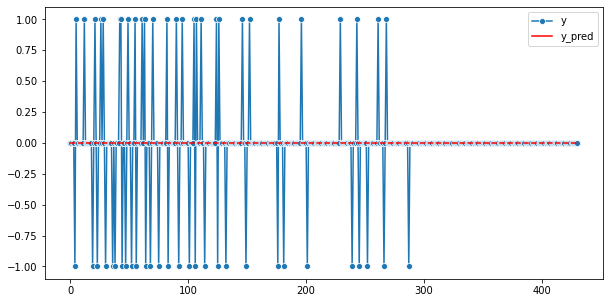

In [ ]:
i = 5
y = list(df_all_info.y.iloc[i])
y_pred = list(df_all_info.y_pred.iloc[i])
y_baseline = list(df_all_info.y_baseline.iloc[i])

ax = sns.lineplot(data = y, label = "y", marker = 'o')
ax = sns.lineplot(data = y_pred, color = "red", label = "y_pred")
ax.lines[1].set_linestyle("--")
print(df_all_info.transition_matrix.iloc[i])

In [ ]:
print(df_all_info.same_as_baseline.value_counts())
print("\nAverage performance: ", np.round(df_all_info.compare_metric.mean(), 4))

True     925
False    120
Name: same_as_baseline, dtype: int64

Average performance:  0.0017


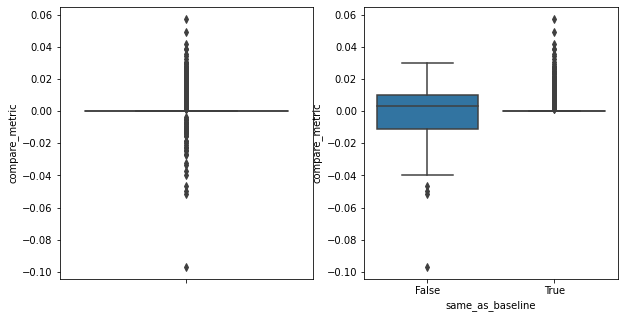

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data = df_all_info, y = "compare_metric", ax = ax[0])
sns.boxplot(data = df_all_info, x = "same_as_baseline", y = "compare_metric", ax = ax[1])

###### Same company products

In [ ]:
company_id_list = list(df_all_flt.company_id.unique())

In [ ]:
all_info = []
count = 0

for company_id in company_id_list:

  count = count + 1
  print(count, "/", len(company_id_list))

  # Get data
  data = df_all_flt[df_all_flt.company_id == company_id]
  X, y = get_X_y(data, ["states"], 1)

  # Get baseline
  baseline = BASELINE()
  y_baseline = baseline.predict(X)

  # Get model
  model = SIMPLE_MARKOV(n_states = 3)
  model = model.fit(X, y)
  transition_matrix, decision_matrix = model.get_params_2()
  y_pred = cross_val_predict(model, X, y, cv = 5)

  # Metrics
  product_id_list = list(data.index.unique())
  y = y.to_numpy()
  for product_id in product_id_list:

    y_product_id = y[X.reset_index().product_id == product_id]
    y_pred_product_id = y_pred[X.reset_index().product_id == product_id]
    y_baseline_product_id = y_baseline[X.reset_index().product_id == product_id]

    metric = np.mean(abs(y_pred_product_id-y_product_id))
    metric_baseline = np.mean(abs(y_baseline_product_id-y_product_id))

    info = {"product_id": product_id,
            "company": data.loc[product_id].company.unique()[0],
            "company_id": data.loc[product_id].company_id.unique()[0],
            "product_group_id": data.loc[product_id].product_group_id.unique()[0],
            "country": data.country.unique()[0],
            "product": data["product"].unique()[0],
            "offer_type": data.offer_type.unique()[0],
            "X": X.reset_index()[X.reset_index().product_id == product_id].set_index("product_id"),
            "y": y_product_id,
            "y_pred": y_pred_product_id,
            "y_baseline": y_baseline_product_id,
            "transition_matrix": transition_matrix,
            "decision_matrix": decision_matrix,
            "model" : "simple_markov_company",
            "n_changes" : data.loc[product_id].n_changes.unique()[0],
            "n_samples" : data.loc[product_id].n_samples.unique()[0],
            "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
            "metric": metric,
            "metric_baseline": metric_baseline,
            "compare_metric" : metric - metric_baseline,
            "same_as_baseline": all(decision_matrix == 0)}
            
    all_info.append(info)
      
df_all_info_same_company = pd.DataFrame(all_info)
df_all_info_same_company.to_pickle("discrete_approach_markov_chains_simple_markov_same_company")

1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25
25 / 25


In [ ]:
df_all_info_same_company = pd.read_pickle("discrete_approach_markov_chains_simple_markov_same_company")

In [ ]:
print(df_all_info_same_company.same_as_baseline.value_counts())
print("\nAverage performance: ", np.round(df_all_info_same_company.compare_metric.mean(), 4))

True    1045
Name: same_as_baseline, dtype: int64

Average performance:  0.0001


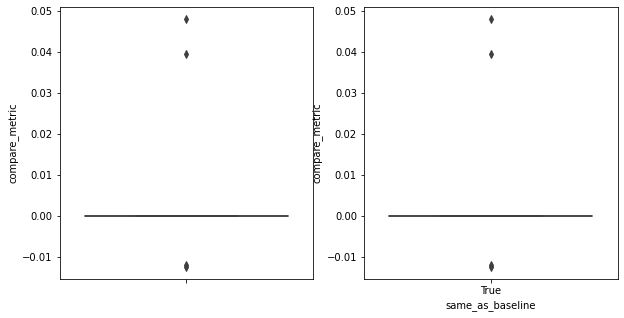

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data = df_all_info_same_company, y = "compare_metric", ax = ax[0])
sns.boxplot(data = df_all_info_same_company, x = "same_as_baseline", y = "compare_metric", ax = ax[1])

#### Double Markov

###### Individual Products

In [ ]:
product_id_list = list(df_all_flt.index.unique())
product_id_list.remove(2804)

In [ ]:
all_info = []
count = 0

for product_id in product_id_list:

  count = count + 1
  print(count, "/", len(product_id_list))

  # Get data
  data = df_all_flt.loc[product_id]
  X, y = get_X_y(data, ["states"], 2)

  # Get baseline
  baseline = BASELINE()
  y_baseline = baseline.predict(X)

  # Get model
  model = SIMPLE_MARKOV(n_states = 3)
  model = model.fit(X, y)
  transition_matrix, decision_matrix = model.get_params_2()
  y_pred = cross_val_predict(model, X, y, cv = 5)

  # Metrics
  metric = np.mean(abs(y_pred-y))
  metric_baseline = np.mean(abs(y_baseline-y))

  info = {"product_id": product_id,
          "company": data.loc[product_id].company.unique()[0],
          "company_id": data.loc[product_id].company_id.unique()[0],
          "product_group_id": data.loc[product_id].product_group_id.unique()[0],
          "country": data.country.unique()[0],
          "product": data["product"].unique()[0],
          "offer_type": data.offer_type.unique()[0],
          "X": X,
          "y": y,
          "y_pred": y_pred,
          "y_baseline": y_baseline,
          "transition_matrix": transition_matrix,
          "decision_matrix": decision_matrix,
          "model" : "double_markov_individual",
          "n_changes" : data.loc[product_id].n_changes.unique()[0],
          "n_samples" : data.loc[product_id].n_samples.unique()[0],
          "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
          "metric": metric,
          "metric_baseline": metric_baseline,
          "compare_metric" : metric - metric_baseline,
          "same_as_baseline": all(decision_matrix == 0)}

  all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("discrete_approach_markov_chains_double_markov_individual")

1 / 1044
2 / 1044
3 / 1044
4 / 1044
5 / 1044
6 / 1044
7 / 1044
8 / 1044
9 / 1044
10 / 1044
11 / 1044
12 / 1044
13 / 1044
14 / 1044
15 / 1044
16 / 1044
17 / 1044
18 / 1044
19 / 1044
20 / 1044
21 / 1044
22 / 1044
23 / 1044
24 / 1044
25 / 1044
26 / 1044
27 / 1044
28 / 1044
29 / 1044
30 / 1044
31 / 1044
32 / 1044
33 / 1044
34 / 1044
35 / 1044
36 / 1044
37 / 1044
38 / 1044
39 / 1044
40 / 1044
41 / 1044
42 / 1044
43 / 1044
44 / 1044
45 / 1044
46 / 1044
47 / 1044
48 / 1044
49 / 1044
50 / 1044
51 / 1044
52 / 1044
53 / 1044
54 / 1044
55 / 1044
56 / 1044
57 / 1044
58 / 1044
59 / 1044
60 / 1044
61 / 1044
62 / 1044
63 / 1044
64 / 1044
65 / 1044
66 / 1044
67 / 1044
68 / 1044
69 / 1044
70 / 1044
71 / 1044
72 / 1044
73 / 1044
74 / 1044
75 / 1044
76 / 1044
77 / 1044
78 / 1044
79 / 1044
80 / 1044
81 / 1044
82 / 1044
83 / 1044
84 / 1044
85 / 1044
86 / 1044
87 / 1044
88 / 1044
89 / 1044
90 / 1044
91 / 1044
92 / 1044
93 / 1044
94 / 1044
95 / 1044
96 / 1044
97 / 1044
98 / 1044
99 / 1044
100 / 1044
101 / 10

In [ ]:
df_all_info = pd.read_pickle("discrete_approach_markov_chains_double_markov_individual")

In [ ]:
print(df_all_info.same_as_baseline.value_counts())
print("\nAverage performance: ", np.round(df_all_info.compare_metric.mean(), 4))

False    1033
True       11
Name: same_as_baseline, dtype: int64

Average performance:  0.0083


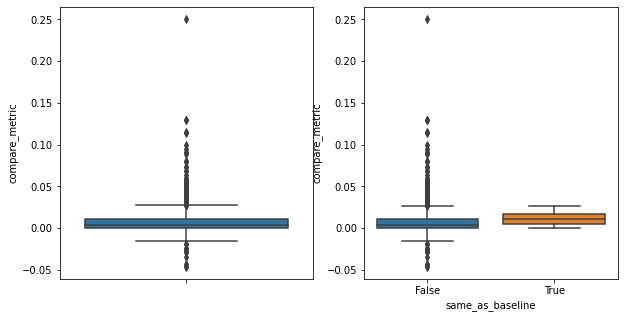

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data = df_all_info, y = "compare_metric", ax = ax[0])
sns.boxplot(data = df_all_info, x = "same_as_baseline", y = "compare_metric", ax = ax[1])

###### Same company products

In [ ]:
company_id_list = list(df_all_flt.company_id.unique())

In [ ]:
all_info = []
count = 0

for company_id in company_id_list:

  count = count + 1
  print(count, "/", len(company_id_list))

  # Get data
  data = df_all_flt[df_all_flt.company_id == company_id]
  X, y = get_X_y(data, ["states"], 2)

  # Get baseline
  baseline = BASELINE()
  y_baseline = baseline.predict(X)

  # Get model
  model = SIMPLE_MARKOV(n_states = 3)
  model = model.fit(X, y)
  transition_matrix, decision_matrix = model.get_params_2()
  y_pred = cross_val_predict(model, X, y, cv = 5)

  # Metrics
  product_id_list = list(data.index.unique())
  if 2804 in product_id_list:
    product_id_list.remove(2804)
  y = y.to_numpy()
  for product_id in product_id_list:

    y_product_id = y[X.reset_index().product_id == product_id]
    y_pred_product_id = y_pred[X.reset_index().product_id == product_id]
    y_baseline_product_id = y_baseline[X.reset_index().product_id == product_id]

    metric = np.mean(abs(y_pred_product_id-y_product_id))
    metric_baseline = np.mean(abs(y_baseline_product_id-y_product_id))

    info = {"product_id": product_id,
            "company": data.loc[product_id].company.unique()[0],
            "company_id": data.loc[product_id].company_id.unique()[0],
            "product_group_id": data.loc[product_id].product_group_id.unique()[0],
            "country": data.country.unique()[0],
            "product": data["product"].unique()[0],
            "offer_type": data.offer_type.unique()[0],
            "X": X.reset_index()[X.reset_index().product_id == product_id].set_index("product_id"),
            "y": y_product_id,
            "y_pred": y_pred_product_id,
            "y_baseline": y_baseline_product_id,
            "transition_matrix": transition_matrix,
            "decision_matrix": decision_matrix,
            "model" : "double_markov_company",
            "n_changes" : data.loc[product_id].n_changes.unique()[0],
            "n_samples" : data.loc[product_id].n_samples.unique()[0],
            "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
            "metric": metric,
            "metric_baseline": metric_baseline,
            "compare_metric" : metric - metric_baseline,
            "same_as_baseline": all(decision_matrix == 0)}
            
    all_info.append(info)
      
df_all_info_same_company = pd.DataFrame(all_info)
df_all_info_same_company.to_pickle("discrete_approach_markov_chains_double_markov_same_company")

1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25
25 / 25


In [ ]:
df_all_info_same_company = pd.read_pickle("discrete_approach_markov_chains_double_markov_same_company")

In [ ]:
print(df_all_info_same_company.same_as_baseline.value_counts())
print("\nAverage performance: ", np.round(df_all_info_same_company.compare_metric.mean(), 4))

True     533
False    511
Name: same_as_baseline, dtype: int64

Average performance:  0.0001


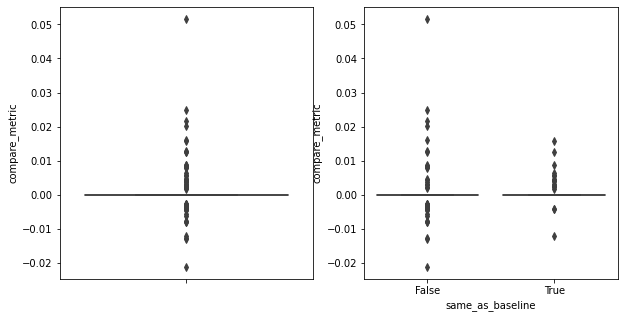

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data = df_all_info_same_company, y = "compare_metric", ax = ax[0])
sns.boxplot(data = df_all_info_same_company, x = "same_as_baseline", y = "compare_metric", ax = ax[1])

#### Week Markov

###### Same company products

In [ ]:
company_id_list = list(df_all_flt.company_id.unique())

In [ ]:
all_info = []
count = 0

for company_id in company_id_list:

  count = count + 1
  print(count, "/", len(company_id_list))

  # Get data
  data = df_all_flt[df_all_flt.company_id == company_id]

  # Get markov week models
  X_week = []
  y_week = []
  y_pred_week = []
  y_baseline_week = []
  transition_matrix_week = []
  decision_matrix_week = []
  for weekday in range(0, 7):

    # Get week data
    data_week = data[data.weekday == weekday]
    X, y = get_X_y(data_week, ["states"], 1)
    X_week.append(X)
    y_week.append(y)

    # Get baseline
    baseline = BASELINE()
    y_baseline = baseline.predict(X)
    y_baseline_week.append(y_baseline)

    # Get model
    model = SIMPLE_MARKOV(n_states = 3)
    model = model.fit(X, y)
    transition_matrix, decision_matrix = model.get_params_2()
    y_pred = cross_val_predict(model, X, y, cv = 5)
    y_pred_week.append(y_pred)
    transition_matrix_week.append(transition_matrix)
    decision_matrix_week.append(decision_matrix)
    
  X = pd.concat(X_week)
  y = pd.concat(y_week)
  y_pred = np.concatenate(y_pred_week)
  y_baseline = np.concatenate(y_baseline_week)
  
  # Metrics
  product_id_list = list(data.index.unique())
  if 2804 in product_id_list:
    product_id_list.remove(2804)
  y = y.to_numpy()
  for product_id in product_id_list:

    y_product_id = y[X.reset_index().product_id == product_id]
    y_pred_product_id = y_pred[X.reset_index().product_id == product_id]
    y_baseline_product_id = y_baseline[X.reset_index().product_id == product_id]

    metric = np.mean(abs(y_pred_product_id-y_product_id))
    metric_baseline = np.mean(abs(y_baseline_product_id-y_product_id))

    info = {"product_id": product_id,
            "company": data.loc[product_id].company.unique()[0],
            "company_id": data.loc[product_id].company_id.unique()[0],
            "product_group_id": data.loc[product_id].product_group_id.unique()[0],
            "country": data.country.unique()[0],
            "product": data["product"].unique()[0],
            "offer_type": data.offer_type.unique()[0],
            "X": X.reset_index()[X.reset_index().product_id == product_id].set_index("product_id"),
            "y": y_product_id,
            "y_pred": y_pred_product_id,
            "y_baseline": y_baseline_product_id,
            "transition_matrix": transition_matrix_week,
            "decision_matrix": decision_matrix_week,
            "model" : "week_markov_company",
            "n_changes" : data.loc[product_id].n_changes.unique()[0],
            "n_samples" : data.loc[product_id].n_samples.unique()[0],
            "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
            "metric": metric,
            "metric_baseline": metric_baseline,
            "compare_metric" : metric - metric_baseline,
            "same_as_baseline": all(y_pred_product_id == y_baseline_product_id)}
            
    all_info.append(info)
      
df_all_info_same_company = pd.DataFrame(all_info)
df_all_info_same_company.to_pickle("discrete_approach_markov_chains_week_markov_same_company")

1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25
25 / 25


In [ ]:
df_all_info_same_company = pd.read_pickle("discrete_approach_markov_chains_week_markov_same_company")

In [ ]:
print(df_all_info_same_company.same_as_baseline.value_counts())
print("\nAverage performance: ", np.round(df_all_info_same_company.compare_metric.mean(), 4))

True     1022
False      22
Name: same_as_baseline, dtype: int64

Average performance:  0.0001


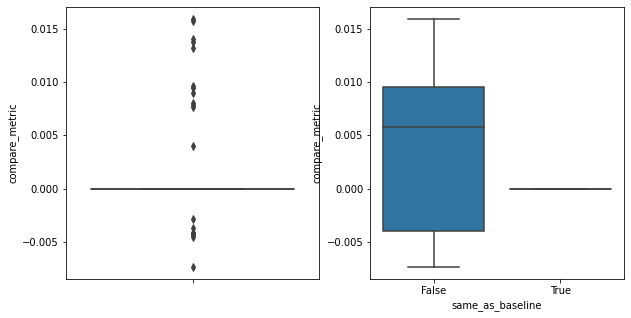

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data = df_all_info_same_company, y = "compare_metric", ax = ax[0])
sns.boxplot(data = df_all_info_same_company, x = "same_as_baseline", y = "compare_metric", ax = ax[1])

## Analyze Predictions

In [ ]:
filenames = ["discrete_approach_markov_chains_simple_markov_individual",
             "discrete_approach_markov_chains_simple_markov_same_company",
             "discrete_approach_markov_chains_double_markov_individual",
             "discrete_approach_markov_chains_double_markov_same_company",
             "discrete_approach_markov_chains_week_markov_same_company"]

all_info = []
for filename in filenames:
  all_info.append(pd.read_pickle(filename))

all_info[4].transition_matrix = np.nan
all_info[4].decision_matrix = np.nan
df_markov = pd.concat(all_info)

In [ ]:
df_markov.groupby(by = "model").compare_metric.mean()

model
double_markov_company       0.000147
double_markov_individual    0.008312
simple_markov_company       0.000061
simple_markov_individual    0.001718
week_markov_company         0.000089
Name: compare_metric, dtype: float64

In [ ]:
df_markov.groupby(by = "model").compare_metric.std()

model
double_markov_company       0.002617
double_markov_individual    0.017426
simple_markov_company       0.001994
simple_markov_individual    0.008595
week_markov_company         0.001269
Name: compare_metric, dtype: float64

In [ ]:
df_markov.groupby(by = "model").same_as_baseline.value_counts()

model                     same_as_baseline
double_markov_company     True                 533
                          False                511
double_markov_individual  False               1033
                          True                  11
simple_markov_company     True                1045
simple_markov_individual  True                 925
                          False                120
week_markov_company       True                1022
                          False                 22
Name: same_as_baseline, dtype: int64